In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import List
import tqdm
from sklearn.metrics import r2_score


from sparks.data.nlb.nwb_interface import NWBDataset
from sparks.data.base import BaseDataset
from sparks.models.sparks import SPARKS
from sparks.models.dataclasses import HebbianAttentionConfig, AttentionConfig
from sparks.utils.train import train
from sparks.utils.test import test

# Overview

This notebook is a demonstration of SPARKS using the Area2_Bump dataset from the Neural Latents Benchmark (https://neurallatents.github.io/)
It assumes some familiarity with the data, to get an overview of it please see: https://github.com/neurallatents/neurallatents.github.io/blob/master/notebooks/area2_bump.ipynb.
In the following, we only consider passive recordings. We will go through the creation of custom Pytorch datasets for loading of the data, training of the algorithm, and some analysis of the results

First, let's obtain the hand positions and corresponding neural responses for each trial in this session.

In [ ]:
dataset_path = "/path/to/000127/sub-Han/"  # Change to your local path
dataset = NWBDataset(dataset_path, "*train", split_heldout=False) # NWB dataset

# Normalize the target between [0, 1] if it's not 'direction' (which is categorical)
dataset.data['hand_pos'] = (dataset.data['hand_pos'] - dataset.data['hand_pos'].min()) / (dataset.data['hand_pos'].max() - dataset.data['hand_pos'].min())

trial_mask = (~dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none') # Keep only active trials  
unique_angles = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0] # Targets angles

lag = 40  # Assumed lag between neural data and behaviour, taken from the NLB notebook
align_range = (-100, 500)  # 100 ms before to 500 ms after the stimulus onset
align_field = 'move_onset_time'

lag_align_range = (align_range[0] + lag, align_range[1] + lag)


# Obtain train/test data for each angle
align_data_train = [dataset.make_trial_data(align_field=align_field, align_range=align_range,
                                            ignored_trials=~(trial_mask  
                                                                & (dataset.trial_info['cond_dir'] == angle)
                                                                & (dataset.trial_info['split'] == 'train')))
                                            for angle in unique_angles]
align_data_test = [dataset.make_trial_data(align_field=align_field, align_range=align_range,
                                            ignored_trials=~(trial_mask 
                                                            & (dataset.trial_info['cond_dir'] == angle)
                                                            & (dataset.trial_info['split'] == 'val')))
                                            for angle in unique_angles]

# Obtain corresponding data for the lagged alignment
lag_align_data_train = [dataset.make_trial_data(align_field=align_field, align_range=lag_align_range,
                                                ignored_trials=~(trial_mask 
                                                                    & (dataset.trial_info['cond_dir'] == angle)
                                                                    & (dataset.trial_info['split'] == 'train')))
                                                for angle in unique_angles]
lag_align_data_test = [dataset.make_trial_data(align_field=align_field, align_range=lag_align_range,
                                                ignored_trials=~(trial_mask 
                                                                & (dataset.trial_info['cond_dir'] == angle)
                                                                & (dataset.trial_info['split'] == 'val')))
                                                for angle in unique_angles]

Next, we create a dataset to load the data efficiently. A Pytorch Dataset is essentially an iterable that will retrieve the inputs (here, neural data) and targets (hand position) for each trial.
They typically handle behind the scene whatever transformation you want to apply to each example individually (for instance, downsampling of the images if you're doing computer vision). This is a simplified version of the full code used for the paper, that can handle different types of targets, etc. 

In [3]:
class MonkeyReachingDataset(BaseDataset):
    def __init__(self, 
                 align_data: List,
                 lag_align_data: List) -> None:

        """
        Abstract Dataset for spike encoding

        Parameters
        --------------------------------------

        :param: align_data : List
        list of aligned data for each angle, each element is a DataFrame with 'spikes' and target keys
        :param: lag_align_data : List
        list of lagged aligned data for each angle, each element is a DataFrame with 'spikes' and target keys
        :param: y_keys : str
        target key to use, e.g. 'hand_pos', 'hand_vel', 'force', 'muscle_len', 'direction', 'joint_ang'
        :param: mode : str
        mode of the dataset, e.g. 'prediction', 'unsupervised', 'spikes_pred'
        :param: smooth : bool
        whether to smooth spikes into FRs
        """

        super(MonkeyReachingDataset).__init__()

        self.x_trial_data = np.vstack([align_data[i]['spikes'].to_numpy().reshape([-1, 600, 65]) 
                                       for i in range(len(align_data))]).transpose(0, 2, 1)
        
        y_dim = lag_align_data[0]['hand_pos'].to_numpy().shape[-1]
        y_trial_data = np.vstack([lag_align_data[i]['hand_pos'].to_numpy().reshape([-1, 600, y_dim])
                                    for i in range(len(lag_align_data))]).transpose([0, 2, 1])

        self.y_trial_data = y_trial_data
        self.y_shape = self.y_trial_data.shape[-2]
        self.x_shape = self.x_trial_data.shape[-2]

    def __len__(self):
        return len(self.x_trial_data)

    def __getitem__(self, index: int):
        """
        :param: index: int
         Index
        :return: tuple: (data, target) where target is index of the target class.
        """

        features = torch.tensor(self.x_trial_data[index]).float()
        target = torch.tensor(self.y_trial_data[index]).float()

        return features, target
    

def get_accuracy(decoder_outputs, targets):
    """"
    Compute accuracy of the model on the test set
    :param: decoder_outputs : torch.Tensor
    model outputs on the test set
    :param: targets : np.ndarray
    ground truth targets on the test dataset
    :return: test_acc : float
    R^2 score of the model on the test set
    """
    preds = decoder_outputs[..., 100:].cpu().numpy().reshape([targets.shape[0], targets.shape[1],
                                                                targets.shape[2] - 100, -1]).transpose(0, 2, 1, 3)
    test_acc = r2_score(targets[..., 100:].transpose(0, 2, 1).reshape(-1, targets.shape[-2]),
                        preds[..., 0].reshape(-1, targets.shape[-2]), multioutput='variance_weighted')

    return test_acc


We can now create the train and test datasets, and corresponding Dataloaders which will randomly sample from them to perform stochastic gradient descent (SGD)

In [4]:
batch_size = 256 # minibatch size to perform SGD 
train_dataset = MonkeyReachingDataset(align_data_train, lag_align_data_train)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MonkeyReachingDataset(align_data_test, lag_align_data_test)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We can now create the SPARKS model instance. By default, the decoding network is chosen as a multilayer perceptron (MLP)

In [ ]:
# if a gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
# If on a recent macbook
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')

# Model parameters
tau_f = 1 # Number of future time-steps to predict
tau_p = 10 # Number of past time-steps to use
embed_dim = 32  # attention embedding dimension
latent_dim = 2 # Latent dimension
dt = 0.001 # dataset time bin width
tau_s = 0.5  # STDP decay period (in seconds)
beta = 0.001  # KDL regularisation strength

hebbian_config = HebbianAttentionConfig(tau_s=tau_s, dt=dt) # Hebbian attention config
attention_config = AttentionConfig() # standard attention config
sparks = SPARKS(n_neurons_per_session=train_dataset.x_shape,
                embed_dim=embed_dim,
                latent_dim=latent_dim,
                tau_p=tau_p,
                tau_f=tau_f,
                hebbian_config=hebbian_config,
                attention_config=attention_config,
                output_dim_per_session=train_dataset.y_shape,
                device=device)

# Optimizer and loss function
optimizer = torch.optim.Adam(sparks.parameters(), lr=0.001)
loss_fn = torch.nn.BCEWithLogitsLoss()

And we can start training a model! With this dataset, the model converges within ~150 epochs, which can be done in less than 10 minutes on a Macbook Pro M2, or under 5 minutes on an NVIDIA L40 GPU.
Training is implemented in high-level functions and can be run in a few lines of code as follows. 

In [6]:
test_period = 10
n_epochs = 150  # Number of training epochs

pbar = tqdm.tqdm(range(n_epochs))
for epoch in pbar:
    train(sparks=sparks,
            train_dls=[train_dl],
            loss_fn=loss_fn,
            optimizer=optimizer,
            beta=beta,
            device=device)

    if (epoch + 1) % test_period == 0:
        test_loss, encoder_outputs, decoder_outputs = test(sparks=sparks,
                                                            test_dls=[test_dl],
                                                            loss_fn=loss_fn,
                                                            act=torch.sigmoid)
        test_acc = get_accuracy(decoder_outputs, test_dataset.y_trial_data)
        pbar.set_description("Epoch %d, acc: %.3f" % (epoch, test_acc))

encoder_outputs = encoder_outputs.cpu().numpy()

Epoch 149, acc: 0.879: 100%|██████████| 150/150 [04:02<00:00,  1.62s/it]


# Having a look at the results

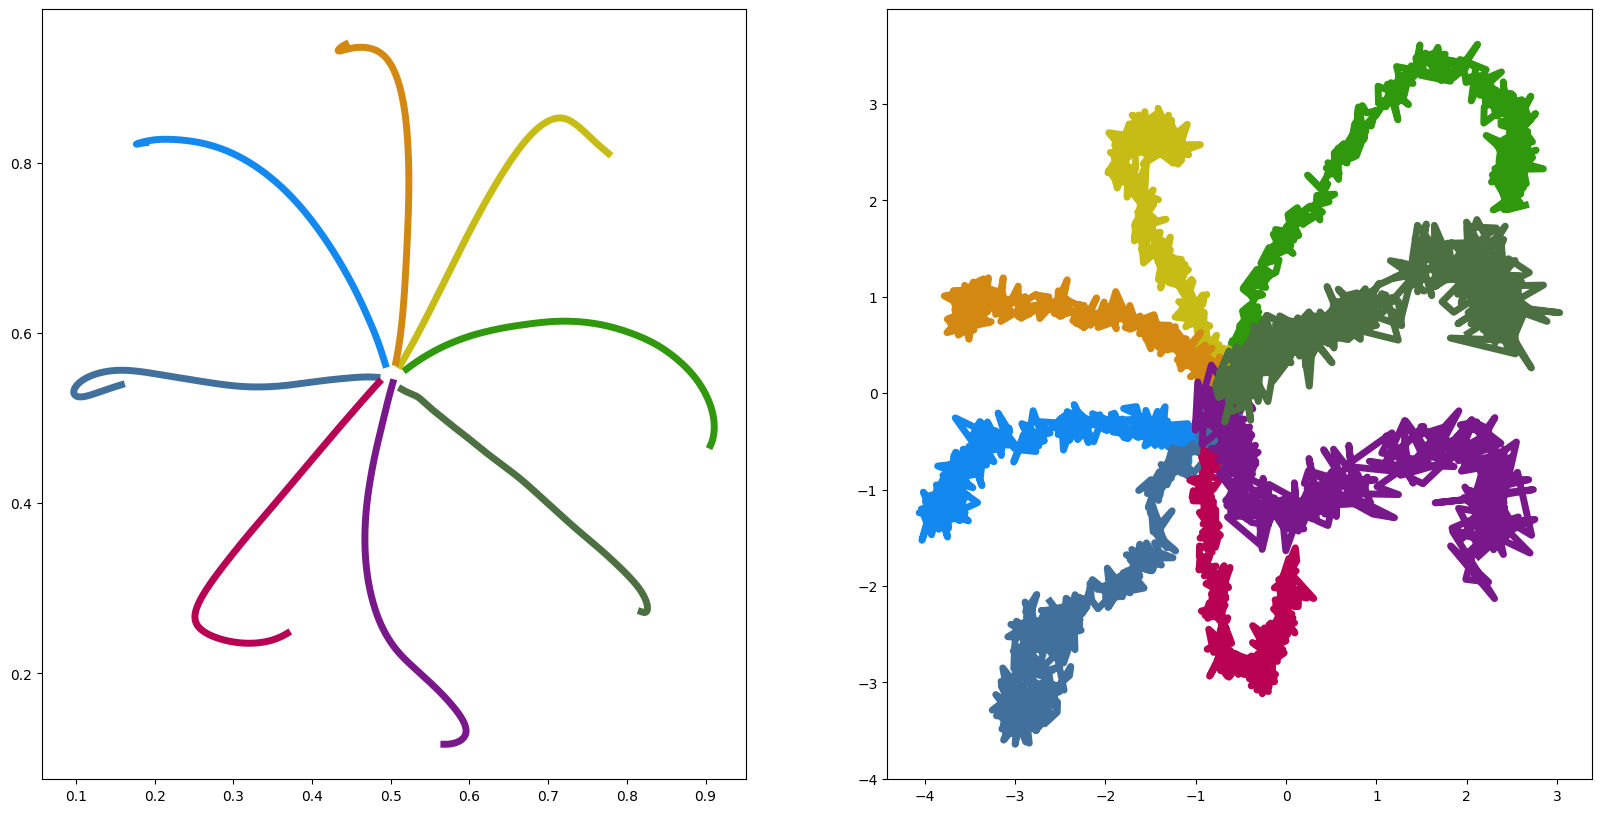

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

n_indices_per_angle = np.array([len(dataset.trial_info[trial_mask & (dataset.trial_info['cond_dir'] == angle)
                                                       & (dataset.trial_info['split'] == 'val')]['split'].to_numpy())
                                                       for angle in unique_angles])
colors = ['#2F980C', '#C7BC16', '#D38811', '#1389F0','#40709B', '#B80152', '#78188B','#4C7041']

for i, angle in enumerate(unique_angles):
    mean_hand_pos = np.mean(test_dataset.y_trial_data[np.sum(n_indices_per_angle[:i]):
                                                      np.sum(n_indices_per_angle[:i+1])], axis=0)[..., 100:] # the first 100 ms are before movement onset
    axs[0].plot(mean_hand_pos[0], mean_hand_pos[1], color=colors[i], linewidth=5)
    mean_encoder_outputs = np.mean(encoder_outputs[np.sum(n_indices_per_angle[:i]):
                                                   np.sum(n_indices_per_angle[:i+1])], axis=0)[:, tau_p:]
    axs[1].plot(mean_encoder_outputs[0, 100 + tau_p:], mean_encoder_outputs[1, 100 + tau_p:], color=colors[i], linewidth=5)

In [10]:
!jupyter nbconvert --to html demo_monkey.ipynb

[NbConvertApp] Converting notebook demo_monkey.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 524087 bytes to demo_monkey.html
